# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [11]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time


## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [12]:
# Define transforms
## YOUR CODE HERE ##
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomResizedCrop(32),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# Create training set and define training dataloader
## YOUR CODE HERE ##
    
batch_size = 256
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# Create test set and define test dataloader
## YOUR CODE HERE ##
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [7]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


truck


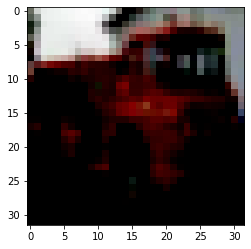

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dog


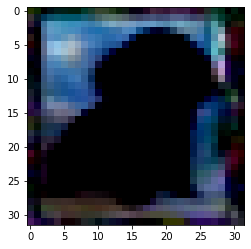

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


car


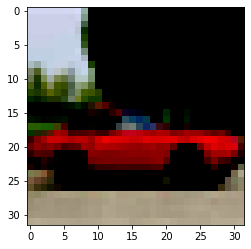

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


deer


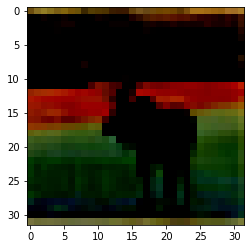

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ship


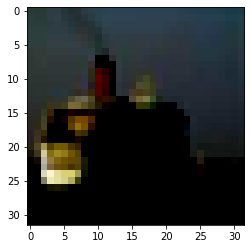

In [8]:
# Explore data
## YOUR CODE HERE ##

show5(trainloader)

In [5]:
dataset_size = len(trainset)
dataset_size

50000

In [6]:
testset_size = len(testset)
testset_size

10000

In [7]:
img, label = trainset[0]
img_shape = img.shape
img_shape

torch.Size([3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Numeric label : 3
Textual label : cat


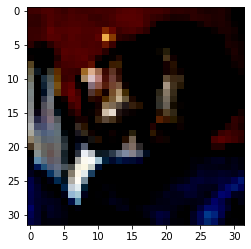

In [9]:
# print the label for the first test image.
img, label = testset[0]
plt.imshow(img.permute(1, 2, 0))
print('Numeric label :', label)
print('Textual label :', classes[label])

In [9]:
# Get count per label in trainset
count = {}
for _, index in trainset:
    label = classes[index]
    if label not in count:
        count[label] = 0
    count[label] += 1
count

{'frog': 5000,
 'truck': 5000,
 'deer': 5000,
 'car': 5000,
 'bird': 5000,
 'horse': 5000,
 'ship': 5000,
 'cat': 5000,
 'dog': 5000,
 'plane': 5000}

In [10]:
# Get count per label in testset
count = {}
for _, index in testset:
    label = classes[index]
    if label not in count:
        count[label] = 0
    count[label] += 1
count

{'cat': 1000,
 'ship': 1000,
 'plane': 1000,
 'frog': 1000,
 'car': 1000,
 'truck': 1000,
 'dog': 1000,
 'horse': 1000,
 'deer': 1000,
 'bird': 1000}

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [11]:
input_size = 3*32*32
output_size = 10
class Cifar10(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 256)
        self.linear2 = nn.Linear(256, 128)
        self.linear3 = nn.Linear(128, output_size)
        
    def forward(self, img):
        # Flatten images into vectors
        output = img.view(img.size(0), -1)
        # Apply fully-connected layers & activation functions
        output = self.linear1(output)
        output = F.relu(output)
        output = self.linear2(output)
        output = F.relu(output)
        output = self.linear3(output)
        return output
    
model = Cifar10()

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [12]:
## YOUR CODE HERE ##

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [26]:
## YOUR CODE HERE ##

# send model data to device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    model.cuda()
else:
    device = torch.device("cpu")
device

device(type='cuda', index=0)

In [18]:
running_loss = 0
print_interval = 5
num_epochs = 10
steps = 0
start = time.time()
for epoch in range(num_epochs):
    # Model in training mode with dropout on
    model.train()
    for inputs, labels in iter(trainloader):
        steps += 1
        optimizer.zero_grad()
        start = time.time()
        # send parameters to device
        inputs, labels = inputs.to(device), labels.to(device)
        output = model.forward(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.data
        if steps % print_interval == 0:
            model.eval()
            accuracy = 0
            test_loss = 0
            for val, (inputs, labels) in enumerate(testloader):
                inputs, labels = inputs.to(device), labels.to(device)
                output = model.forward(inputs)
                test_loss += criterion(output, labels).data
                # Calculate model accuracy
                ps = torch.exp(output).data
                equality = (labels.data == ps.max(1)[1])
                accuracy += equality.type_as(torch.FloatTensor()).mean()
            
            print("Epoch: {}/{}.. ".format(epoch+1, num_epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/print_interval),
                  "Validation Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                  "Validation Accuracy: {:.3f}".format(accuracy/len(testloader)))
            
            running_loss = 0
            model.train()

end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Total training Time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

Epoch: 1/10..  Training Loss: 1.617..  Validation Loss: 1.642..  Validation Accuracy: 0.416
Epoch: 1/10..  Training Loss: 1.666..  Validation Loss: 1.641..  Validation Accuracy: 0.416
Epoch: 1/10..  Training Loss: 1.641..  Validation Loss: 1.641..  Validation Accuracy: 0.416
Epoch: 1/10..  Training Loss: 1.607..  Validation Loss: 1.640..  Validation Accuracy: 0.416
Epoch: 1/10..  Training Loss: 1.608..  Validation Loss: 1.640..  Validation Accuracy: 0.416
Epoch: 1/10..  Training Loss: 1.646..  Validation Loss: 1.639..  Validation Accuracy: 0.419
Epoch: 1/10..  Training Loss: 1.656..  Validation Loss: 1.638..  Validation Accuracy: 0.420
Epoch: 1/10..  Training Loss: 1.656..  Validation Loss: 1.638..  Validation Accuracy: 0.420
Epoch: 1/10..  Training Loss: 1.649..  Validation Loss: 1.638..  Validation Accuracy: 0.420
Epoch: 1/10..  Training Loss: 1.634..  Validation Loss: 1.637..  Validation Accuracy: 0.421
Epoch: 1/10..  Training Loss: 1.647..  Validation Loss: 1.636..  Validation Accu

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [36]:
## YOUR CODE HERE ##

# Validation on the test set
model.eval()
accuracy = 0
test_loss = 0
for val, (inputs, labels) in enumerate(testloader):
    inputs, labels = inputs.to(device), labels.to(device)
    output = model.forward(inputs)
    test_loss += criterion(output, labels).data

    ## Calculating model accuracy on the test dataset
    ps = torch.exp(output).data
    equality = (labels.data == ps.max(1)[1])
    accuracy += equality.type_as(torch.FloatTensor()).mean()

print("Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
      "Test Accuracy: {:.3f}".format((accuracy/len(testloader)*100)))

Test Loss: 1.494..  Test Accuracy: 47.324


## Saving your model
Using `torch.save`, save your model for future loading.

In [21]:
## YOUR CODE HERE ##
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?



## **My Recommendation**

- My Convolutional Neural Network (CNN) model produced an accuracy of 47.324%, which is 2.324% higher than Detectocorp's 45%. So, my model is better.
- Compared to the more advanced solutions at the top of this notebook, my model is far less efficient since its accuracy is less that 70%. I would need to improve my model in order to better compare it with the advanced solutions from **Deep Belief Networks**, for example.
- I started with a CNN made of two fully connected layers but the accuracy was bearly above 5%. So, I improved it to 3 layers but training with 2 epochs gave me just 25% accuracy. I then reduced the learning rate and increased the number of epochs to 10 in order to reduce overfitting and get the current 47.324% accuracy. 
- Yes, it is necessary to improve my accuracy. To do so, it would involve an deeper CNN and training on more epochs. Adding dropout layers to the CNN will also help reduce overfitting and improve the accuracy score.

#### With all this said,  I would recommend building rather than buying because clearly, producing an accuracy as good as those from the advanced solutions would need a lot of man power and finances that just buying available efficient solutions that would better serve Detectocorp.


## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).